In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file (API token)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivabuddepu","key":"6bfdf64f75b6878b3750692feac61a30"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!pip install Kaggle

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle/kaggle.json'

In [ ]:
!kaggle datasets download -d mmasodulrahmanusmani/isic-2024-skin-cancer-detection-with-3d-tbp

Dataset URL: https://www.kaggle.com/datasets/mmasodulrahmanusmani/isic-2024-skin-cancer-detection-with-3d-tbp
License(s): unknown
 99% 1.99G/2.00G [00:16<00:00, 180MB/s]
100% 2.00G/2.00G [00:16<00:00, 132MB/s]


In [ ]:
!unzip /content/isic-2024-skin-cancer-detection-with-3d-tbp.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/ISIC/train-image/image/ISIC_9874656.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874659.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874663.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874742.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874751.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874803.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874805.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874832.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874878.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874897.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874925.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874931.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874939.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_9874940.jpg  
  inflating: /content/ISIC/train-image/image/ISIC_987

In [ ]:
# Load Metadata
train_metadata = pd.read_csv('/content/ISIC/train-metadata.csv')

<ipython-input-8-d414092278eb>:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv('/content/ISIC/train-metadata.csv')


In [ ]:
# Balance dataset
class_0 = train_metadata[train_metadata['target'] == 0]
class_1 = train_metadata[train_metadata['target'] == 1]

In [ ]:
# Oversample minority class using augmentation
def augment_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f" {image_path}")
    image = cv2.resize(image, img_size)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    datagen = ImageDataGenerator(
        rotation_range=20,          # Increase rotation to allow more variations (original: 10)
        width_shift_range=0.3,     # Slightly increase width shifting (original: 0.2)
        height_shift_range=0.3,    # Slightly increase height shifting (original: 0.2)
        shear_range=0.15,          # Reduce shear to avoid excessive distortion (original: 0.2)
        zoom_range=0.25,           # Slightly increase zoom for better focus variability (original: 0.2)
        horizontal_flip=True,      # Keep horizontal flip for better augmentation
        vertical_flip=True,        # Add vertical flip to introduce more diversity
        brightness_range=[0.8, 1.2],  # Adjust brightness for better lighting variations
        fill_mode='nearest'
        )
    g_iter = datagen.flow(image, batch_size=1)
    return aug_iter.next()[0]

augmented_images = []
augmented_labels = []
for index, row in class_1.iterrows():
    img_path = os.path.join('/content/ISIC/train-image', f"{row['isic_id']}.jpg")
    for _ in range(1000):  # Generate multiple augmented samples
        try:
            aug_img = augment_image(img_path)
            augmented_images.append(aug_img)
            augmented_labels.append(1)
        except FileNotFoundError as e:
            print(e)

Streaming output truncated to the last 5000 lines.
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-image/ISIC_9877311.jpg
 /content/ISIC/train-imag

In [ ]:
# Combine original and augmented data
balanced_images = np.array(augmented_images)
balanced_labels = np.array(augmented_labels)

In [ ]:
# Preprocess Images
def preprocess_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found or unable to read: {image_path}")
    image = cv2.resize(image, img_size)
    image = image / 255.0
    return image

In [ ]:
# Generator for batch processing
def image_batch_generator(metadata, batch_size=32):
    num_samples = len(metadata)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = metadata.iloc[offset:offset+batch_size]
            images = []
            labels = []
            for _, row in batch_samples.iterrows():
                img_id = row['isic_id']
                img_path = os.path.join('/content/ISIC/train-image/image', f"{img_id}.jpg")
                if not os.path.exists(img_path):
                    continue
                try:
                    image = preprocess_image(img_path)
                    images.append(image)
                    labels.append(row['target'])
                except FileNotFoundError as e:
                    print(e)
                    continue
            yield np.array(images), np.array(labels)

In [ ]:
# Define model
def build_model(input_shape):
    base_model = applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    return model

input_shape = (224, 224, 3)
model = build_model(input_shape)
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
batch_size = 32
train_generator = image_batch_generator(train_metadata, batch_size=batch_size)
steps_per_epoch = len(train_metadata) // batch_size

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Load Metadata
train_metadata = pd.read_csv('/content/ISIC/train-metadata.csv')

# Separate majority and minority classes
majority_class = train_metadata[train_metadata['target'] == 0]
minority_class = train_metadata[train_metadata['target'] == 1]

# Oversample the minority class
minority_oversampled = resample(
    minority_class,
    replace=True,  # Sample with replacement
    n_samples=len(majority_class),  # Match the majority class count
    random_state=42
)

# Combine the oversampled minority class with the majority class
balanced_data = pd.concat([majority_class, minority_oversampled])

# Shuffle the dataset to mix the classes
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Number of images labeled 0:", balanced_data['target'].value_counts()[0])
print("Number of images labeled 1:", balanced_data['target'].value_counts()[1])



<ipython-input-16-3cac27d484fa>:5: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv('/content/ISIC/train-metadata.csv')


Number of images labeled 0: 400666
Number of images labeled 1: 400666


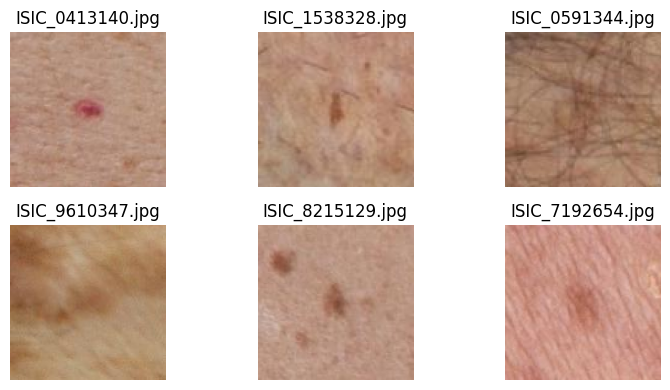

In [ ]:
import matplotlib.pyplot as plt
import os

# Path to the training images
train_image_path = '/content/ISIC/train-image/image'

# Get a list of image files
image_files = os.listdir(train_image_path)

# Display some sample images
plt.figure(figsize=(8,4))
for i in range(6):
    img_path = os.path.join(train_image_path, image_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(image_files[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

<ipython-input-1-f0cd5ac0ca1f>:5: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  labels_df = pd.read_csv('/content/ISIC/train-metadata.csv')
<ipython-input-1-f0cd5ac0ca1f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labels_df, x='target', palette='viridis')


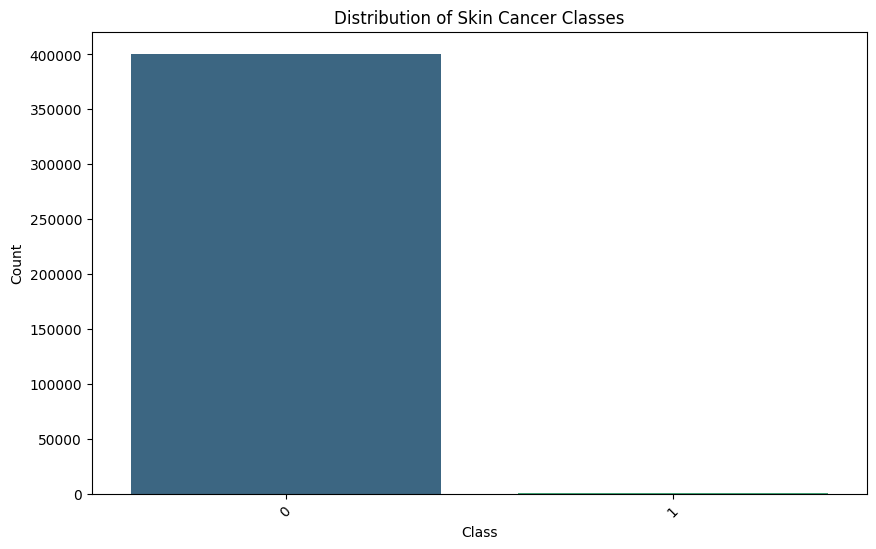

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Load the CSV file containing labels
labels_df = pd.read_csv('/content/ISIC/train-metadata.csv')

# Plot the distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(data=labels_df, x='target', palette='viridis')
plt.title('Distribution of Skin Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<ipython-input-6-168e524b70ed>:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv('/content/ISIC/train-metadata.csv')


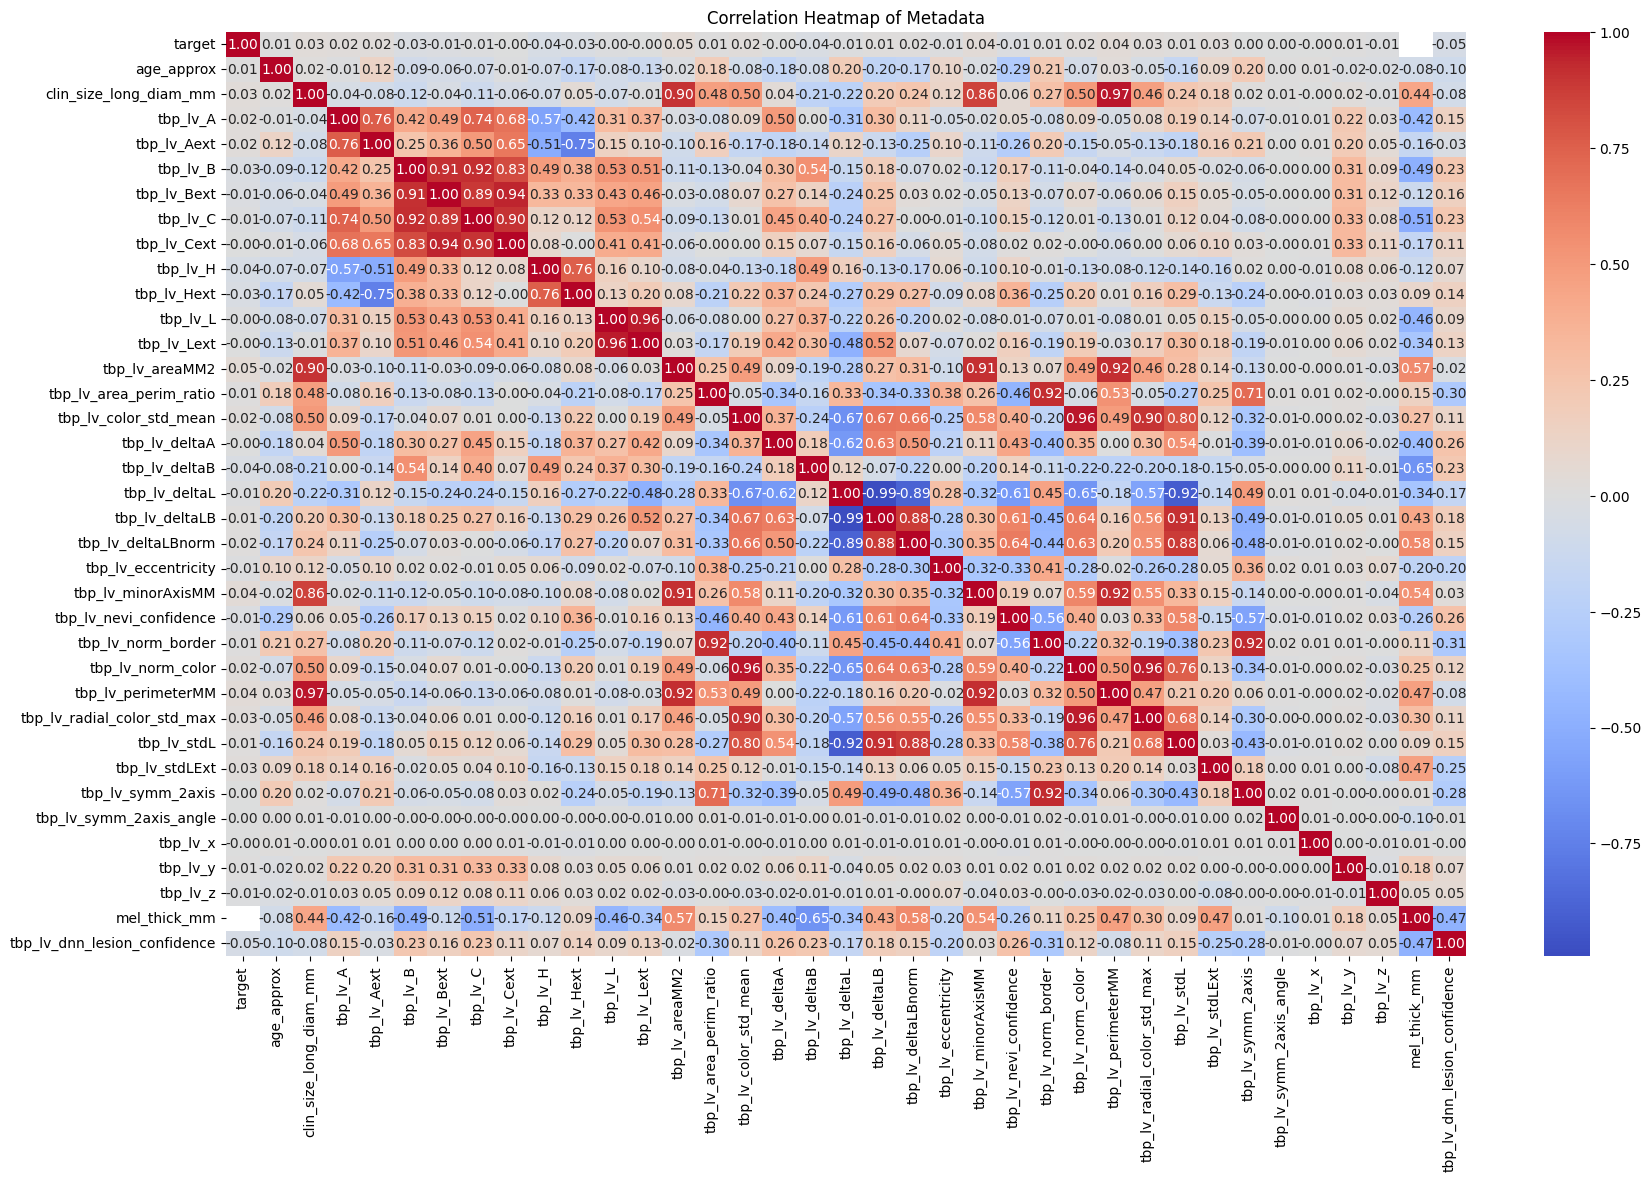

In [ ]:
# Assuming metadata_df is a DataFrame with additional metadata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
metadata_df = pd.read_csv('/content/ISIC/train-metadata.csv')

# Select only numeric columns for correlation calculation
numeric_df = metadata_df.select_dtypes(include=np.number)
corr = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Metadata')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/content/train-metadata.csv")

# Set the style for seaborn
sns.set_style("whitegrid")

# 1. Age Distribution
plt.figure(figsize=(8,5))
sns.histplot(df["age_approx"].dropna(), bins=10, kde=True, color='blue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# 2. Sex Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df["sex"], palette="coolwarm")
plt.title("Sex Distribution")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

# 3. Lesion Location Distribution
plt.figure(figsize=(10,5))
sns.countplot(y=df["anatom_site_general"], order=df["anatom_site_general"].value_counts().index, palette="viridis")
plt.title("Lesion Location Distribution")
plt.xlabel("Count")
plt.ylabel("Anatomical Site")
plt.show()

# 4. Correlation Heatmap (for numerical values)
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# 5. Lesion Confidence Distribution
plt.figure(figsize=(8,5))
sns.histplot(df["tbp_lv_dnn_lesion_confidence"], bins=10, kde=True, color='red')
plt.title("Lesion Confidence Score Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Count")
plt.show()
